In [1]:
#Import necessary modules
from IPython import get_ipython
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import find_peaks

In [2]:
#Determining movement type
movement = input("If you would like to analyze squat-to-stand type squat\n" +
                 "If you would like to analyze sit-to-stand type sit\n" +
                 "If you would like to analyze gait cycle type gait\n")

If you would like to analyze squat-to-stand type squat
If you would like to analyze sit-to-stand type sit
If you would like to analyze gait cycle type gait
gait


In [3]:
#Import Data
if movement == 'squat':
    File = 'C:/Users/julie/Year 5 Kin/RD-EMG-Analysis/RD_Squat_Stand.csv'
    File2 = 'C:/Users/julie/Year 5 Kin/RD-EMG-Analysis/LASI_Squat data.csv'
    LASI = pd.read_csv(File2, header = 0)

elif movement == 'sit':
    File = 'C:/Users/julie/Year 5 Kin/RD-EMG-Analysis/RD_Sit_Stand_EMG.csv'
    File2 = 'C:/Users/julie/Year 5 Kin/RD-EMG-Analysis/LASI_Sit data.csv'
    LASI = pd.read_csv(File2, header = 0)
    
elif movement == 'gait':
    File = 'C:/Users/julie/Year 5 Kin/RD-EMG-Analysis/RD_Walk_EMG.csv'

emg = pd.read_csv(File, header = 0)

In [4]:
#Resampling LASI from 100Hz to 2000 Hz
if movement == 'sit' or movement == 'squat':
    x = LASI['Y3']
    x_resampled = signal.resample(x, 48620)

    plt.figure()
    fig, ax = plt.subplots(1, figsize = (15,10))
    ax.plot(x_resampled)

In [5]:
#Sampling frequency
sfreq = 2000

#Setting time column
emg['delta_t'] = 1/sfreq
emg['real_time'] = np.cumsum(emg['delta_t'])
emg = emg.set_index('real_time')
if movement == 'gait':
    emg = emg.iloc[25010:98423]

In [6]:
#Determining side to analyze 
val = input("Type right to analyze the right side\n" +
            "Type left to analyze the left side\n")
if val == 'right':
    GM = 'R_GM'
    ST = 'R_ST'
    BF = 'R_BF'
elif val == 'left':
    GM = 'L_GM'
    ST = 'L_ST'
    BF = 'L_BF'

Type right to analyze the right side
Type left to analyze the left side
right


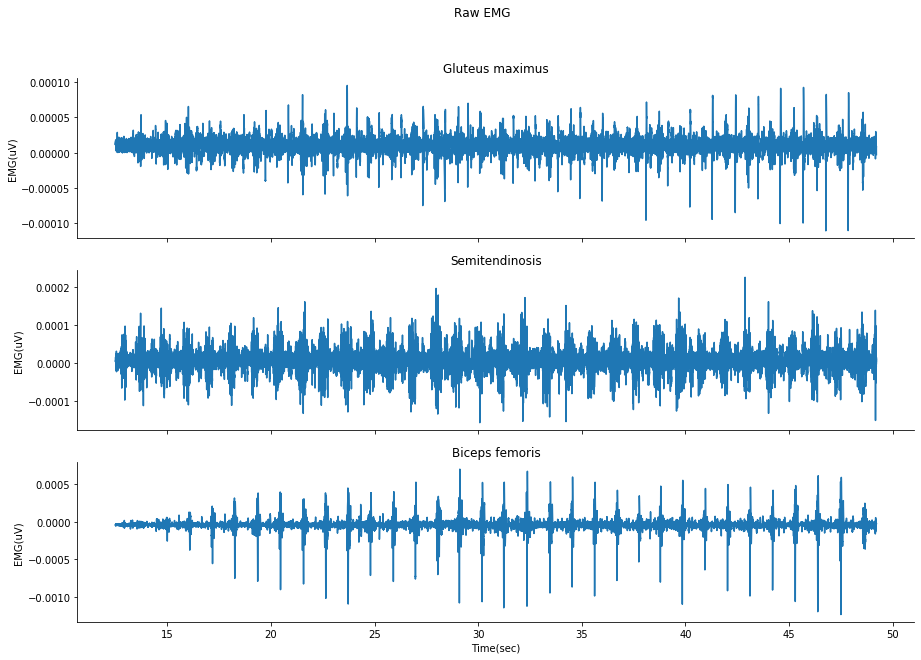

In [7]:
#Visualizing data
def custom_plot(suptitle, x,
                y1, y2, y3):
    """Subplots of EMG data"""
    fig, axs = plt.subplots(3, figsize =(15,10))
    fig.suptitle(suptitle)
    axs[0].plot(x, y1)
    axs[0].set_title('Gluteus maximus')

    axs[1].plot(x, y2)
    axs[1].set_title('Semitendinosis')

    axs[2].plot(x, y3)
    axs[2].set_title('Biceps femoris')

    for ax in axs.flat:
        ax.set(xlabel = 'Time(sec)', ylabel = 'EMG(uV)')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    
    for ax in axs.flat:
        ax.label_outer()

custom_plot('Raw EMG', emg.index, emg[GM], emg[ST], emg[BF])

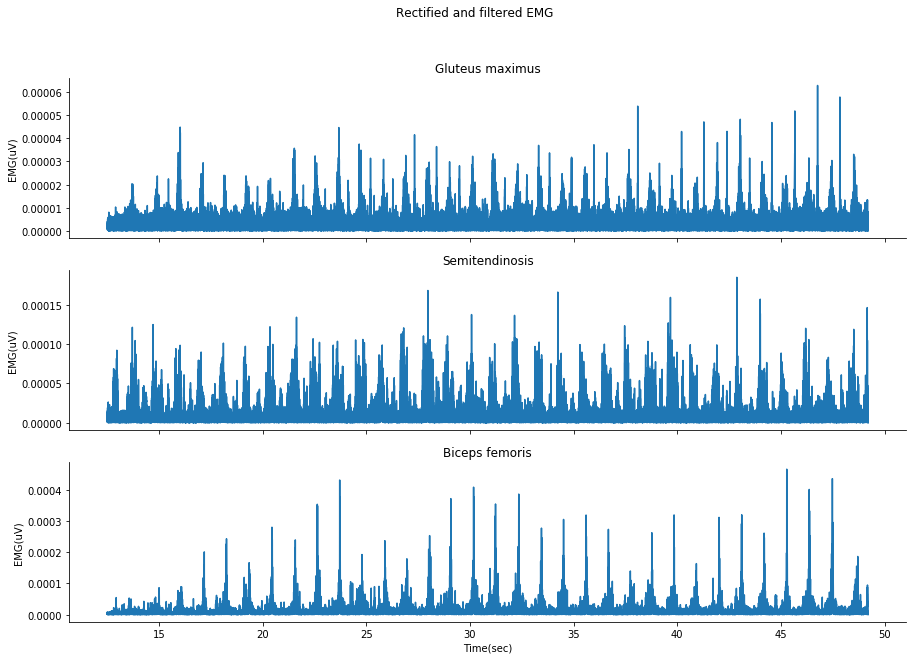

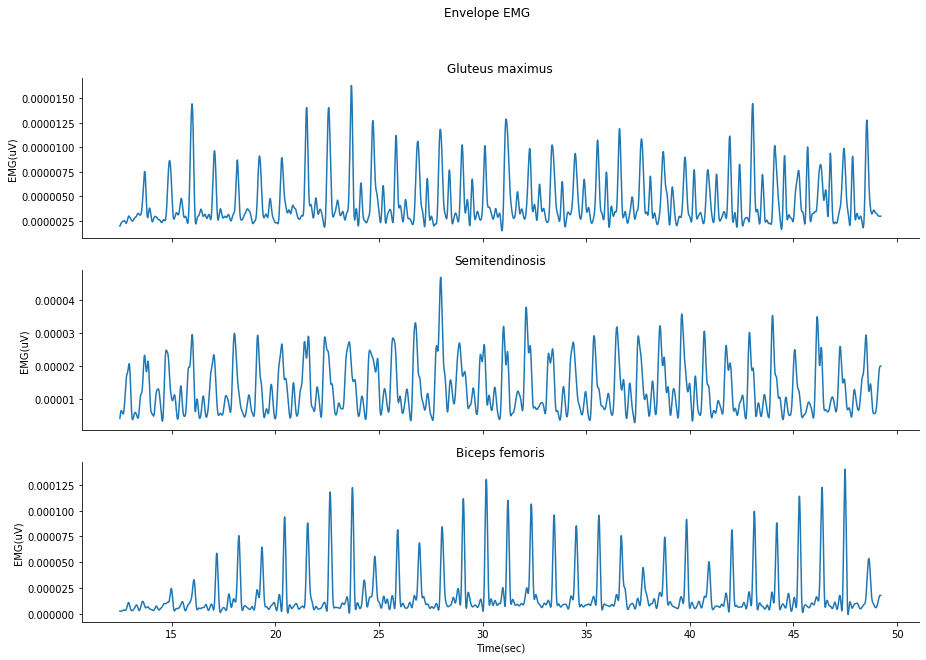

In [8]:
#Filtering data 

#Band Pass Filtering
def Band_Pass(Muscle):
    """Band Pass filter for EMG data"""
    High_fc = 30
    Low_fc = 300
    HighPass = High_fc/(sfreq/2)
    LowPass = Low_fc/(sfreq/2)
    b, a = signal.butter(4, [HighPass, LowPass], btype = 'bandpass')
    emg_filter = signal.filtfilt(b, a, Muscle, padlen = 0)
    return emg_filter

NewEMG = emg.apply(Band_Pass)

#Fullwave rectify
emg_rectified = abs(NewEMG)
custom_plot('Rectified and filtered EMG', emg_rectified.index, emg_rectified[GM], emg_rectified[ST], emg_rectified[BF])

#EMG envelope
def Envelope(Muscle):
    """Low Pass filter to create EMG envelope"""
    Low_fc = 5
    b_e, a_e = signal.butter(4, Low_fc/(sfreq/2), btype = 'lowpass')
    emg_filter = signal.filtfilt(b_e, a_e, Muscle, padlen = 0)
    return emg_filter

#Threshold Detection
EMG_envelope = emg_rectified.apply(Envelope)
custom_plot('Envelope EMG', EMG_envelope.index, EMG_envelope[GM], EMG_envelope[ST],EMG_envelope[BF])
EMG_envelope['sample'] = (np.linspace(1, len(EMG_envelope), num = len(EMG_envelope))).astype(int)
EMG_envelope = EMG_envelope.set_index('sample')

In [9]:
#Finding the peaks of the rest sections
if movement == 'squat':
    x_resampled = pd.DataFrame(x_resampled)
    x_resampled = x_resampled.rename(columns = {0: 'Y3'})
    x_resampled['Y3'] = x_resampled['Y3'] * -1
    x_resampled['Y3'] = x_resampled.loc[5000:, 'Y3'].replace(np.nan)
    plt.figure()
    plt.plot(x_resampled)
    
    peaks = find_peaks(x_resampled['Y3'], height = -550, distance = 6500)
    height = peaks[1]['peak_heights'] #list containing the height of the peaks
    peak_pos = x_resampled.index[peaks[0]] #list of the peaks positions
    
    fig = plt.figure()
    ax = fig.subplots()
    ax.plot(x_resampled['Y3'])
    ax.scatter(peak_pos, height, color = 'r', s = 15, marker = 'D')
    plt.show()
        
elif movement == 'sit':
    x_resampled = pd.DataFrame(x_resampled)
    x_resampled = x_resampled.rename(columns = {0: 'Y3'})
    x_resampled['Y3'] = x_resampled['Y3'] * -1
    x_resampled['Y3'] = x_resampled.loc[200:, 'Y3'].replace(np.nan)
    plt.figure()
    plt.plot(x_resampled)

    peaks = find_peaks(x_resampled['Y3'], height = -700, distance = 6500)
    height = peaks[1]['peak_heights'] #list containing the height of the peaks
    peak_pos = x_resampled.index[peaks[0]] #list of the peaks positions
    
    fig = plt.figure()
    ax = fig.subplots()
    ax.plot(x_resampled['Y3'])
    ax.scatter(peak_pos, height, color = 'r', s = 15, marker = 'D')
    plt.show()

        
elif movement == 'gait':
    peaks = find_peaks(EMG_envelope['R_ST'], height = 0.00002, distance = 1000)
    height = peaks[1]['peak_heights'] #list containing the height of the peaks
    peak_pos = EMG_envelope.index[peaks[0]] #list of the peaks positions

In [10]:
#Phase averaging the gait cycle based on ST activation
array_ST = EMG_envelope[ST].to_numpy()
array_GM = EMG_envelope[GM].to_numpy()
array_BF = EMG_envelope[BF].to_numpy()
subarray_ST = []
subarray_GM = []
subarray_BF = []

for i in range(1, len(peak_pos)):
    subarray_ST.append(array_ST[peak_pos[i - 1]:peak_pos[i]])
    subarray_GM.append(array_GM[peak_pos[i - 1]:peak_pos[i]])
    subarray_BF.append(array_BF[peak_pos[i - 1]:peak_pos[i]])

<Figure size 432x288 with 0 Axes>

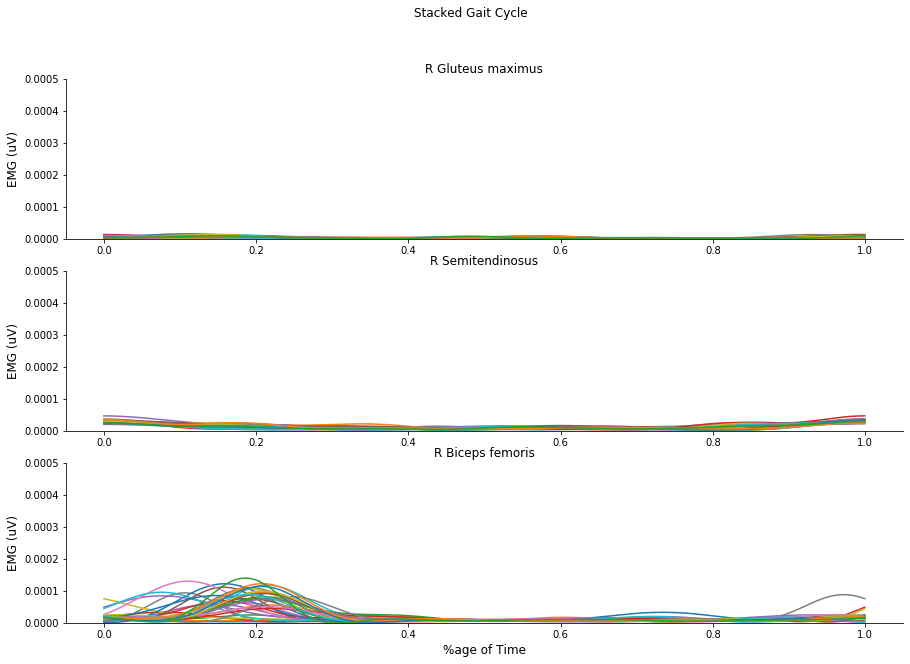

In [11]:
#Setting time column
EMG_envelope['delta_t'] = 1/sfreq
EMG_envelope['real_time'] = np.cumsum(EMG_envelope['delta_t'])

#Plotting muscle activation
if movement == 'squat':
    suptitle = 'Stacked Squat to Stand'
    
elif movement == 'sit':
    suptitle = 'Stacked Sit to Stand'
    
elif movement == 'gait':
    suptitle = 'Stacked Gait Cycle'
    
plt.figure()
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize = (15,10))
fig.suptitle(suptitle)

#Converting time to %age of time
for i in range(len(subarray_ST)):
    k = list(range(0, len(subarray_GM[i])))
    GM_X = []
    for number in k:
        GM_X.append(number/len(subarray_GM[i]))
        
    l = list(range(0, len(subarray_ST[i])))
    ST_X = []
    for number in l:
        ST_X.append(number/len(subarray_ST[i]))
        
    m = list(range(0, len(subarray_BF[i])))
    BF_X = []
    for number in m:
        BF_X.append(number/len(subarray_BF[i]))
    
    ax1.plot(GM_X, subarray_GM[i])
    ax2.plot(ST_X, subarray_ST[i])
    ax3.plot(BF_X, subarray_BF[i])
    

def simpleaxis(ax, title, lim = 0.00008, xlabel = None):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title)
    ax.title.set_size(12)
    ax.set_xlabel(xlabel, fontsize = 12)
    ax.set_ylabel('EMG (uV)', fontsize = 12)
    ax.set_ylim(0, lim)
    
if val == 'right':
    GM_title = 'R Gluteus maximus'
    ST_title = 'R Semitendinosus'
    BF_title = 'R Biceps femoris'
    
elif val == 'left': 
    GM_title = 'L Gluteus maximus'
    ST_title = 'L Semitendinosus'
    BF_title = 'L Biceps femoris'   

#Change lim number to alter the y axes for the final graph
#For gait lim = 0.0005
#For squat and sit lim = 0.00008
if movement == 'gait':
    simpleaxis(ax1, GM_title, lim = 0.0005)
    simpleaxis(ax2, ST_title, lim = 0.0005)
    simpleaxis(ax3, BF_title, lim = 0.0005, xlabel = '%age of Time')
    plt.show()

elif movement == 'sit' or movement == 'squat':
    simpleaxis(ax1, GM_title, lim = 0.00008)
    simpleaxis(ax2, ST_title, lim = 0.00008)
    simpleaxis(ax3, BF_title, lim = 0.00008, xlabel = '%age of Time')
    plt.show()
